# Introducción a Machine Learning con IRIS

# Contenidos

## 1. Introducción

## 2. Datos

### 2.1 Fuente de datos

### 2.2 Limpieza de datos

### 2.3 Codificación de valores

### 2.4 Estudio de los datos

## 3. Entrenar el modelo

## 4. Validar el modelo

## 5. Predicciones

## 6. Conclusiones



----------------

## 1. Introducción
Existen dos tipos de problemas a tratar con ML:
    1. Supervisados: Los datos está etiquetados, el motor de ML usa las etiquetas para aprender.
    2. No supervisados: Intentamos que el método aprenda solo, sin ningún tipo de etiquetado.

En este webinar nos vamos a centrar en los supervisados


### Supervisados
Son de dos tipos fundamentales:
    1. Clasificación: se predice una propiedad: ¿es un gato o un perro?.
    2. Regresión: se predice el valor numérico de una propiedad. Por ejemplo el valor de un piso.

### Paquetes python

In [ ]:
# Import packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Sklearn Packages
from sklearn.model_selection import train_test_split

# Visualizes all the columns
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Pandas dataframes

Los Pandas dataframes son una estructura de datos bidimensional, mutable y que puede guardar datos heterogéneos.

Vamos a guardar y leer Pandas dataframes usando IRIS, para ello empleamos el código de este artículo de la [developer community](https://community.intersystems.com/post/save-pandas-dataframe-iris-quick-note)

In [ ]:
def to_sql_iris(cursor, dataFrame, tableName, schemaName='SQLUser', drop_table=False ):
        """"
        Dynamically insert dataframe into an IRIS table via SQL by "excutemany" 
        
        Inputs:
            cursor:      Python JDBC or PyODBC cursor from a valid and establised DB connection
            dataFrame:   Pandas dataframe
            tablename:   IRIS SQL table to be created, inserted or apended
            schemaName:  IRIS schemaName, default to "SQLUser"
            drop_table:  If the table already exsits, drop it and re-create it if True; othrewise keep it and appen 
        Output:
            True is successful; False if there is any exception.
        """
        if drop_table:   
            try:                 
                #print("Drop table!")
                curs.execute("DROP TABLE %s.%s" %(schemaName, tableName))
                #print("Dropped!")
            except Exception:
                pass
        
        try: 
            dataFrame.columns = dataFrame.columns.str.replace("[() -]", "_")
            curs.execute(pd.io.sql.get_schema(dataFrame, tableName))
        except Exception:
            pass
        
        curs.fast_executemany = True
        cols = ", ".join([str(i) for i in dataFrame.columns.tolist()])
        wildc =''.join('?, ' * len(dataFrame.columns))
        wildc = '(' + wildc[:-2] + ')'
        sql = "INSERT INTO " + tableName + " ( " + cols.replace('-', '_') + " ) VALUES" + wildc
        #print(sql)
        curs.executemany(sql, list(dataFrame.itertuples(index=False, name=None)) )
        return True

### Conexión a IRIS usando el driver jdbc 

In [ ]:
import jaydebeapi
#url = "jdbc:IRIS://192.168.128.1:8091/USER" 
url = "jdbc:IRIS://irisimlsvr:1972/USER" 
driver = 'com.intersystems.jdbc.IRISDriver'
user = "SuperUser"
password = "SYS"
jarfile = "./intersystems-jdbc-3.1.0.jar"
conn = jaydebeapi.connect(driver, url, [user, password], jarfile)
curs = conn.cursor()

## 2. Datos

Utilizando datos del satélite [Kepler](https://es.wikipedia.org/wiki/Kepler_(telescopio_espacial)) de NASA vamos a predecir si se ha encontrado un exoplaneta.
  

In [ ]:
!df

In [ ]:
# Importamos los datos
df = pd.read_csv('exoplanets_2018.csv')

# Vemos el tamaño
print(df.shape)

# Descripción de los datos
df.describe()

### Limpieza de los datos

#### Renombrar columnas

In [ ]:
df = df.rename(columns={'kepid':'KepID',
'kepoi_name':'KOIName',
'kepler_name':'KeplerName',
'koi_disposition':'ExoplanetArchiveDisposition',
'koi_pdisposition':'DispositionUsingKeplerData',
'koi_score':'DispositionScore',
'koi_fpflag_nt':'NotTransit_LikeFalsePositiveFlag',
'koi_fpflag_ss':'koi_fpflag_ss',
'koi_fpflag_co':'CentroidOffsetFalsePositiveFlag',
'koi_fpflag_ec':'EphemerisMatchIndicatesContaminationFalsePositiveFlag',
'koi_period':'OrbitalPeriod_days',
'koi_period_err1':'OrbitalPeriodUpperUnc_days',
'koi_period_err2':'OrbitalPeriodLowerUnc_days',
'koi_time0bk':'TransitEpoch_BKJD',
'koi_time0bk_err1':'TransitEpochUpperUnc_BKJD',
'koi_time0bk_err2':'TransitEpochLowerUnc_BKJD',
'koi_impact':'ImpactParamete',
'koi_impact_err1':'ImpactParameterUpperUnc',
'koi_impact_err2':'ImpactParameterLowerUnc',
'koi_duration':'TransitDuration_hrs',
'koi_duration_err1':'TransitDurationUpperUnc_hrs',
'koi_duration_err2':'TransitDurationLowerUnc_hrs',
'koi_depth':'TransitDepth_ppm',
'koi_depth_err1':'TransitDepthUpperUnc_ppm',
'koi_depth_err2':'TransitDepthLowerUnc_ppm',
'koi_prad':'PlanetaryRadius_Earthradii',
'koi_prad_err1':'PlanetaryRadiusUpperUnc_Earthradii',
'koi_prad_err2':'PlanetaryRadiusLowerUnc_Earthradii',
'koi_teq':'EquilibriumTemperature_K',
'koi_teq_err1':'EquilibriumTemperatureUpperUnc_K',
'koi_teq_err2':'EquilibriumTemperatureLowerUnc_K',
'koi_insol':'InsolationFlux_Earthflux',
'koi_insol_err1':'InsolationFluxUpperUnc_Earthflux',
'koi_insol_err2':'InsolationFluxLowerUnc_Earthflux',
'koi_model_snr':'TransitSignal_to_Nois',
'koi_tce_plnt_num':'TCEPlanetNumbe',
'koi_tce_delivname':'TCEDeliver',
'koi_steff':'StellarEffectiveTemperature_K',
'koi_steff_err1':'StellarEffectiveTemperatureUpperUnc_K',
'koi_steff_err2':'StellarEffectiveTemperatureLowerUnc_K',
'koi_slogg':'StellarSurfaceGravity_log10',
'koi_slogg_err1':'StellarSurfaceGravityUpperUnc_log10',
'koi_slogg_err2':'StellarSurfaceGravityLowerUnc_log10',
'koi_srad':'StellarRadius_Solarradii',
'koi_srad_err1':'StellarRadiusUpperUnc_Solarradii',
'koi_srad_err2':'StellarRadiusLowerUnc_Solarradii',
'ra':'RA_decimaldegrees',
'dec':'Dec_decimaldegrees',
'koi_kepmag':'Kepler-band_mag'
})
df.head(30)

## Codificación de valores

El catálogo ya contiene una columna que indica si el exoplaneta ha sido confirmado mediante otras observaciones.

Vamos a convertir esa columna en 3 valores numéricos y así podemos comparar las predicciones de AutoML con los resultados validados.

Exoplaneta confirmado = 2

Candidato             = 1

Falso positivo        = 0

Como hay 3 valores diferentes a predecir es un problema de regresión.


In [ ]:
df['ExoplanetConfirmed'] = df['ExoplanetArchiveDisposition'].apply(lambda x: 2 if x == 'CONFIRMED' else 1 if x == 'CANDIDATE' else 0 )

In [ ]:
df.head(30)

### Limpieza de datos: quitar datos que no hacen falta 

In [ ]:
#df.drop(columns=['KeplerName'], inplace=True)
df.drop(columns=['KeplerName','KOIName','EquilibriumTemperatureUpperUnc_K', 'KepID',
                 'ExoplanetArchiveDisposition','DispositionUsingKeplerData',
                 'NotTransit_LikeFalsePositiveFlag','koi_fpflag_ss','CentroidOffsetFalsePositiveFlag',
                 'EphemerisMatchIndicatesContaminationFalsePositiveFlag','TCEDeliver',
                 'EquilibriumTemperatureLowerUnc_K'], inplace=True)

### Limpieza de datos: aquellos que contengan NaNs

In [ ]:
# Hay columnas sin valores numéricos?
df.isna().any()

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.shape

# Exploramos los datos

In [ ]:
# Histograms
df.hist(figsize=(24,18), zorder=2, rwidth=1.1)
plt.show()
# Vemos los histogramas de cada columna, nos hacemos una idea de cuántos casos con valor parecido hay

In [ ]:
# Matriz de correlación: indica la relación entre dos datos diferentes.
# Para cada pareja de datos sirve para responder a la pregunta: ¿si un dato aumenta cómo se comparta el otro? 
# Puede suceder que aumente (entonces la correlación es positiva)
# Puede suceder que disminuya (entonces la correlación es negativa)
# o que sea indiferente y entonces será 0 o muy próxima a cero 
plt.figure(figsize=(35,35))
corr = df.corr()
corr.index = df.columns
#matrix = np.triu(df.corr())
sns.heatmap(corr, annot = True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Matrix de correlación", fontsize=16)
plt.show()


## Dividimos los datos entre entrenamiento y validación

In [ ]:
train, test = train_test_split(df, random_state=1, test_size=.40)

In [ ]:
iris_schema = 'SQLUser'
iris_table = 'KeplerTrain'

In [ ]:
#Guardar training data
to_sql_iris(curs, train, iris_table, iris_schema, drop_table=True)   


In [ ]:
#Guardar testing data
iris_table='KeplerTesting'
to_sql_iris(curs, test, iris_table, iris_schema, drop_table=True)   
    

# Entrenar modelo

In [ ]:
dataTable = 'SQLUser.KeplerTrain'
dataColumn =  'DispositionScore'
modelName = "AutoMLKepler"  

In [ ]:
#curs.execute("Drop MODEL %s"%(modelName))
curs.execute("CREATE MODEL %s PREDICTING (%s)  FROM %s" % (modelName, dataColumn, dataTable))
curs.execute("TRAIN MODEL %s FROM %s" % (modelName, dataTable))
conn.commit()

## Validar el modelo

In [ ]:
#curs.execute("Drop INFORMATION_SCHEMA.ML_VALIDATION_METRICS")
curs.execute("VALIDATE MODEL AutoMLKepler FROM SQLUser.KeplerTesting")
df_val = pd.read_sql("SELECT * FROM INFORMATION_SCHEMA.ML_VALIDATION_METRICS ", conn)
display(df_val)


# Predicciones

In [ ]:
dataTablePredict = 'SQLUser.KeplerPredict'
dataColumnPredict = "Predicción"

In [ ]:
#curs.execute("Drop table %s"%(dataTablePredict))
dataColumnConfirmed="ExoplanetConfirmed"
curs.execute("Create Table %s (%s VARCHAR(100), %s VARCHAR(100), %s VARCHAR(100))" % (dataTablePredict, dataColumnPredict, dataColumn,dataColumnConfirmed))
curs.execute("INSERT INTO %s  SELECT TOP 50 PREDICT(%s) AS %s, %s, %s FROM %s" % (dataTablePredict, modelName, dataColumnPredict, dataColumn,dataColumnConfirmed, dataTable))

In [ ]:
from IPython.display import display

df1 = pd.read_sql("SELECT * from %s ORDER BY ID" % dataTablePredict, conn)
display(df1)

#Exoplaneta confirmado = 2
#Candidato             = 1
#Falso positivo        = 0

In [ ]:
df3 = pd.read_sql("SELECT * FROM INFORMATION_SCHEMA.ML_TRAINED_MODELS", conn)
display(df3)

# Conclusiones
Entrenar un modelo con IRIS es sencillo. En este caso los resultados son buenos y no hace falta mucho trabajo.

IRIS se encarga de todo el proceso:

1. Almacena los datos
1. Limpia los datos
2. Entrena el modelo y guardar el resultado
3. Valida el modelo
4. Puede predecir probabilidades usando el modelo
5. Despliega el modelo y hace predicciones

## Detección de exoplanetas
Generalmente se detectan midiendo la variación del brillo


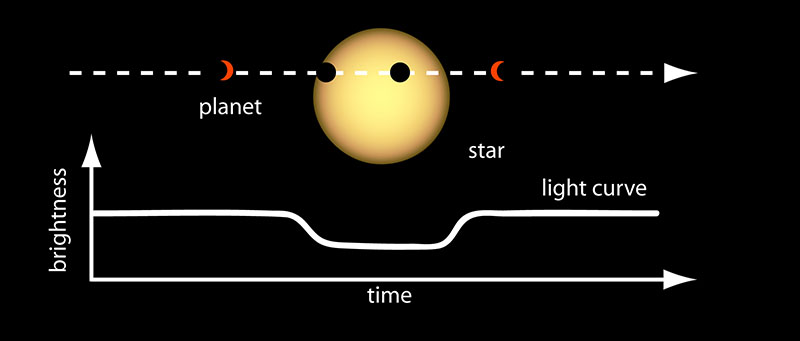
Créditos: [NASA](https://exoplanets.nasa.gov/resources/280/light-curve-of-a-planet-transiting-its-star/)

Vídeo de NASA del tránsito de un planeta:

https://youtu.be/8v4SRfmoTuU

TESS es el sucesor de Kepler:

https://youtu.be/uOxuTLPAlzI

Archivo con todos los datos de exoplanetas de NASA:

https://exoplanetarchive.ipac.caltech.edu/

El satélite Cheops de ESA está buscando exoplanetas:
    
 [Cheops](https://www.esa.int/Science_Exploration/Space_Science/Cheops/A_perfect_blur_First_image_by_exoplanet_watcher_Cheops)

ESA tiene otro satélite llamado Gaia que está midiendo el brillo de estrellas:

Principales [descubrimientos](https://www.esa.int/ESA_Multimedia/Videos/2020/11/Gaia_s_Milky_Way_discoveries)

Datos de Gaia: [Gaia](https://www.cosmos.esa.int/web/gaia/mission-numbers)